In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.transforms import RandomNodeSplit

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
x_all = np.load('/home/docker_current/datasets/graph/nodes.npy', allow_pickle=True)
y_all = np.load('/home/docker_current/datasets/graph/lables.npy', allow_pickle=True)
date = np.load('/home/docker_current/datasets/graph/dates.npy', allow_pickle=True).astype(int)
edges = np.load('/home/docker_current/datasets/graph/edges.npy', allow_pickle=True)
weights = np.load('/home/docker_current/datasets/graph/weights.npy', allow_pickle=True)

# x_all = np.load('/home/docker_current/datasets/graph2/nodes.npy', allow_pickle=True)
# y_all = np.load('/home/docker_current/datasets/graph2/lables.npy', allow_pickle=True)
# date = np.load('/home/docker_current/datasets/graph2/dates.npy', allow_pickle=True).astype(int)
# edges = np.load('/home/docker_current/datasets/graph2/edges.npy', allow_pickle=True)
# weights = np.load('/home/docker_current/datasets/graph2/weights.npy', allow_pickle=True)


y_all[y_all == 'test'] = 2
y_all = y_all.astype(int)

x = torch.tensor(x_all).float()
y = torch.tensor(y_all)
edges = torch.tensor(edges)

date = torch.tensor(date)
weights = torch.tensor(weights)

In [3]:
data = Data(x=x, edge_index=edges, y=y, weights=weights)

In [4]:
data.is_undirected()

True

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim=1, return_embeds=False):
        super().__init__()
        self.convs = torch.nn.ModuleList([
            GCNConv(input_dim, hidden_dim) if i == 0 else GCNConv(hidden_dim, hidden_dim)  for i in range(num_layers - 1)
        ])
        self.out_conv = GATConv(hidden_dim, output_dim, heads=1)
        self.bns = torch.nn.ModuleList([torch.nn.BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])
        self.sigmoid = nn.Sigmoid()
        self.dropout = dropout
        self.return_embeds = return_embeds

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        out = x
        num_layers = len(self.convs)
        for i in range(num_layers - 1):
            out = self.convs[i](out, adj_t)
            out = self.bns[i](out)
            out = F.relu(out)
            out = F.dropout(out, p=self.dropout, training=self.training)

        if not self.return_embeds:
            out = self.out_conv(out, adj_t)
            out = self.sigmoid(out)

        return out

In [6]:
def train(model, data, optimizer, scheduler, loss_fn):
    model.train()
    loss = 0
    optimizer.zero_grad()
    out = model(data.x, data.edge_index).squeeze()
    loss = loss_fn(out[data.train_idx], data.y[data.train_idx].float())
    loss.backward()
    optimizer.step()
    scheduler.step()

    return loss.item()

In [7]:
@torch.no_grad()
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)

    y_pred = out.squeeze().squeeze()

    train_score = roc_auc_score(data.y[data.train_idx].cpu().numpy(), y_pred[data.train_idx].cpu().numpy())
    valid_score = roc_auc_score(data.y[data.val_idx].cpu().numpy(), y_pred[data.val_idx].cpu().numpy())

    return train_score, valid_score

In [8]:
idx = np.arange(len(data.x))
idx = idx[(data.y != -1) & (data.y != 2)]
train_idx, val_idx = train_test_split(idx, test_size=0.2, stratify=data.y[(data.y != -1) & (data.y != 2)], random_state=42)
data.train_idx = torch.tensor(train_idx)
data.val_idx = torch.tensor(val_idx)

In [9]:
# splitter = RandomNodeSplit(split='train_rest', num_val=0.2, num_test=0.1)
# g = splitter(data)

In [10]:
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 128,
    'dropout': 0.2,
    'lr': 3e-3,
    'epochs': 1000,
}
args

{'device': 'cuda',
 'num_layers': 3,
 'hidden_dim': 128,
 'dropout': 0.2,
 'lr': 0.003,
 'epochs': 1000}

In [11]:
model = GCN(data.num_features, args['hidden_dim'], args['num_layers'], args['dropout']).to(device)
# model= nn.DataParallel(model, device_ids = [0, 1])

In [12]:
data.num_features, args['hidden_dim'], args['num_layers'], args['dropout']

(200, 128, 3, 0.2)

In [13]:
data.to(device)

Data(x=[1466558, 200], edge_index=[2, 2776842], y=[1466558], weights=[2776842], train_idx=[101944], val_idx=[25486])

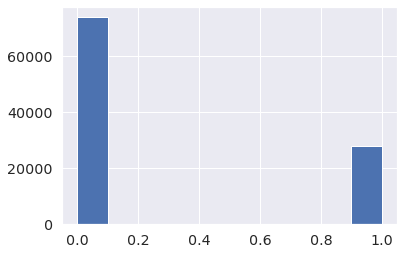

In [14]:
plt.hist(data.y[data.train_idx].cpu().numpy());

In [15]:
# def loss_fn(y_pred, y_true):
#     return -(y_true * torch.log(y_pred) + 0.25 * (1 - y_true) * torch.log(1 - y_pred)).mean()

In [16]:
import copy

model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.85)

best_model = None
best_valid_score = 0

train_loss = []
val_loss = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(model, data, optimizer, scheduler, loss_fn)
    result = test(model, data)
    train_score, valid_score = result
    if valid_score > best_valid_score:
        best_valid_score = valid_score
        best_model = copy.deepcopy(model)
    print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_score:.2f}%,'
        f'Valid: {100 * valid_score:.2f}%')
    train_loss.append(train_score)
    val_loss.append(valid_score)


Epoch: 01, Loss: 1.0446, Train: 48.77%,Valid: 49.27%
Epoch: 02, Loss: 0.8940, Train: 47.82%,Valid: 47.58%
Epoch: 03, Loss: 0.8044, Train: 48.75%,Valid: 48.23%
Epoch: 04, Loss: 0.7527, Train: 50.32%,Valid: 49.81%
Epoch: 05, Loss: 0.7210, Train: 50.77%,Valid: 50.28%
Epoch: 06, Loss: 0.7189, Train: 50.49%,Valid: 49.89%
Epoch: 07, Loss: 0.6830, Train: 50.63%,Valid: 49.96%
Epoch: 08, Loss: 0.6804, Train: 51.16%,Valid: 50.36%
Epoch: 09, Loss: 0.6786, Train: 51.84%,Valid: 51.04%
Epoch: 10, Loss: 0.6719, Train: 52.37%,Valid: 51.79%
Epoch: 11, Loss: 0.6810, Train: 52.50%,Valid: 51.93%
Epoch: 12, Loss: 0.6640, Train: 52.58%,Valid: 51.93%
Epoch: 13, Loss: 0.6631, Train: 52.61%,Valid: 52.01%
Epoch: 14, Loss: 0.6671, Train: 52.54%,Valid: 52.00%
Epoch: 15, Loss: 0.6664, Train: 52.40%,Valid: 51.93%
Epoch: 16, Loss: 0.6600, Train: 52.46%,Valid: 51.98%
Epoch: 17, Loss: 0.6603, Train: 52.67%,Valid: 52.21%
Epoch: 18, Loss: 0.6564, Train: 52.83%,Valid: 52.39%
Epoch: 19, Loss: 0.6683, Train: 52.37%,Valid: 

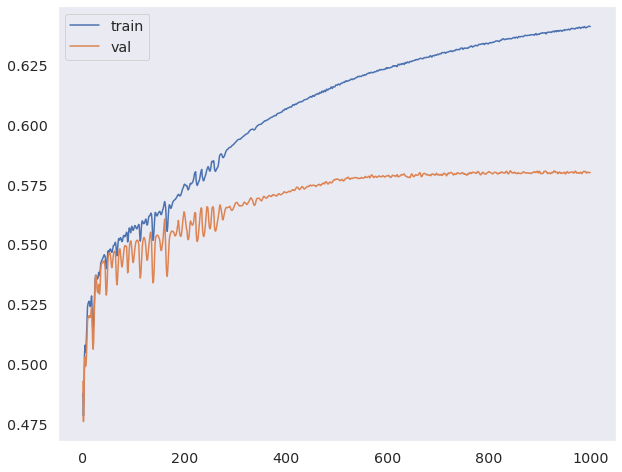

In [17]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="val")
plt.grid()
plt.legend()

In [18]:
max(val_loss)

0.5806683807089279

In [19]:
model.return_embeds = True
embeds = model(data.x, data.edge_index).detach()

In [20]:
torch.save(best_model.state_dict(), 'best_model_1.pth')

In [21]:
X_train = embeds[data.train_idx].cpu().numpy()
X_val = embeds[data.val_idx].cpu().numpy()

y_train = data.y[data.train_idx].cpu().numpy()
y_val = data.y[data.val_idx].cpu().numpy()

In [22]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
        iterations=500,
        learning_rate=0.01,
        silent=False,
        random_seed=42,
        task_type='GPU',
        eval_metric = 'AUC',
        max_depth=10,
    )

model.fit(X_train,
          y_train,
          eval_set=[(
        X_val, 
        y_val)],
          verbose=True)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5544564	best: 0.5544564 (0)	total: 58.1ms	remaining: 29s
1:	total: 112ms	remaining: 27.8s
2:	total: 167ms	remaining: 27.7s
3:	total: 222ms	remaining: 27.5s
4:	total: 276ms	remaining: 27.3s
5:	test: 0.5734034	best: 0.5734034 (5)	total: 330ms	remaining: 27.2s
6:	total: 378ms	remaining: 26.6s
7:	total: 426ms	remaining: 26.2s
8:	total: 475ms	remaining: 25.9s
9:	total: 523ms	remaining: 25.6s
10:	test: 0.5743081	best: 0.5743081 (10)	total: 573ms	remaining: 25.5s
11:	total: 622ms	remaining: 25.3s
12:	total: 671ms	remaining: 25.1s
13:	total: 721ms	remaining: 25s
14:	total: 769ms	remaining: 24.9s
15:	test: 0.5754695	best: 0.5754695 (15)	total: 818ms	remaining: 24.8s
16:	total: 868ms	remaining: 24.6s
17:	total: 917ms	remaining: 24.5s
18:	total: 966ms	remaining: 24.4s
19:	total: 1.02s	remaining: 24.4s
20:	test: 0.5763957	best: 0.5763957 (20)	total: 1.07s	remaining: 24.5s
21:	total: 1.12s	remaining: 24.3s
22:	total: 1.17s	remaining: 24.2s
23:	total: 1.22s	remaining: 24.1s
24:	total: 1.2

In [23]:
from sklearn.metrics import roc_auc_score


preds_class = model.predict_proba(X_val)

roc_auc_score(y_val, preds_class[:, 1])

0.5813044625626076